## **Fake Review Analysis: Impact on Amazon Product Success**
#####  Alexa Gamble, Charlotte Hunter, and Scotland Muir

### **Research Question:**
**How do scam reviews vs. genuine reviews impact the success of Amazon products?**

**Goals:**
- Identify patterns that distinguish **scam** vs. **genuine** reviews.
- Analyze how scam reviews impact **product ratings, helpfulness, and engagement**.
- Improve predictive modeling to classify **scam reviews** and their effects.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool, cpu_count

# Scikit-learn Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.cluster import KMeans

# NLTK for NLP Processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer


In [2]:
nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
%pip install gdown

import gdown

file_id = "14Fi_1BNV6FBGoqdQG85Mxleh6aKjvkzj"

url = f"https://drive.google.com/uc?id={file_id}"

output_file = "Amazon_Reviews.csv"

# Download the file
gdown.download(url, output_file, quiet=False)

df = pd.read_csv(output_file)

df


Note: you may need to restart the kernel to use updated packages.


Downloading...
From (original): https://drive.google.com/uc?id=14Fi_1BNV6FBGoqdQG85Mxleh6aKjvkzj
From (redirected): https://drive.google.com/uc?id=14Fi_1BNV6FBGoqdQG85Mxleh6aKjvkzj&confirm=t&uuid=82ed6ea4-ad16-41c6-a817-8fd008191fa8
To: /home/jovyan/git/mgta-415-final-project-analysis/Amazon_Reviews.csv
100%|██████████| 301M/301M [00:12<00:00, 24.2MB/s] 


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


### **Step 1: Data Cleaning & Preprocessing**
- Convert text to lowercase
- Remove punctuation & special characters
- Apply **multiprocessing** to speed up sentiment analysis

In [4]:
%pip install contractions

Note: you may need to restart the kernel to use updated packages.


In [5]:
import string
import contractions 

def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    
    text = str(text).lower()
    text = contractions.fix(text)
    text = text.translate(translator)
    words_list = word_tokenize(text)
    processed_words = [lemmatizer.lemmatize(word) for word in words_list if word not in stop_words and len(word) > 1]
    
    return " ".join(processed_words)

df['ProcessedText'] = df['Text'].apply(preprocess_text)

### **Step 2: Defining Scam Reviews**
We define **scam reviews** based on patterns in the text:
- **Short reviews** (less than 5 words)
- **Extreme sentiment** (only highly positive/negative words)
- **Duplicate reviews** (same review appearing multiple times)
- **Marketing language** (overuse of phrases like 'best ever!!!', 'unbelievable')

In [6]:
# Precompute duplicated reviews
duplicate_reviews = df['ProcessedText'].duplicated(keep=False)

# Precompute short reviews (avoids calling `.split()` multiple times)
short_reviews = df['ProcessedText'].str.split().str.len() < 5

# Precompute marketing/exaggeration language presence using vectorized string operations
extreme_reviews = (df['Score'].isin([1, 5])) & df['ProcessedText'].str.contains(r'\b(best|worst|amazing|horrible|fake|scam)\b', regex=True)

# Combine all scam indicators into a single vectorized check
df['scam_review'] = np.where(short_reviews | extreme_reviews | duplicate_reviews, 1, 0)

df

/tmp/ipykernel_27181/4186511898.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  extreme_reviews = (df['Score'].isin([1, 5])) & df['ProcessedText'].str.contains(r'\b(best|worst|amazing|horrible|fake|scam)\b', regex=True)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText,scam_review
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanut pe...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confection around century light pillowy citrus...,0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,1
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,0
...,...,...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...,great sesame chicken good better resturants ea...,0
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...,disappointed flavor chocolate note especially ...,0
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",star small give 10 15 one training session tri...,0
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...,best treat training rewarding dog good groomin...,1


In [7]:
print(f"Percentage of duplicated reviews: {duplicate_reviews.mean() * 100:.2f}%")

Percentage of duplicated reviews: 41.11%


### **Step 3: Sentiment Analysis (Optimized with Multiprocessing)**

In [8]:
# Optimized Sentiment Analysis with Multiprocessing
sia = SentimentIntensityAnalyzer()

def batch_sentiment(texts):
    return [list(sia.polarity_scores(text).values()) for text in texts]

num_cores = cpu_count() - 1
chunks = np.array_split(df['ProcessedText'], num_cores)

with Pool(num_cores) as pool:
    results = pool.map(batch_sentiment, chunks)

sentiments = np.vstack(results)
df[['neg_sentiment', 'neu_sentiment', 'pos_sentiment', 'compound_sentiment']] = sentiments

sentiments

/opt/conda/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


array([[ 0.    ,  0.503 ,  0.497 ,  0.9413],
       [ 0.129 ,  0.762 ,  0.11  , -0.1027],
       [ 0.132 ,  0.576 ,  0.292 ,  0.8624],
       ...,
       [ 0.    ,  0.754 ,  0.246 ,  0.886 ],
       [ 0.059 ,  0.243 ,  0.697 ,  0.9738],
       [ 0.    ,  0.741 ,  0.259 ,  0.4215]])

In [9]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


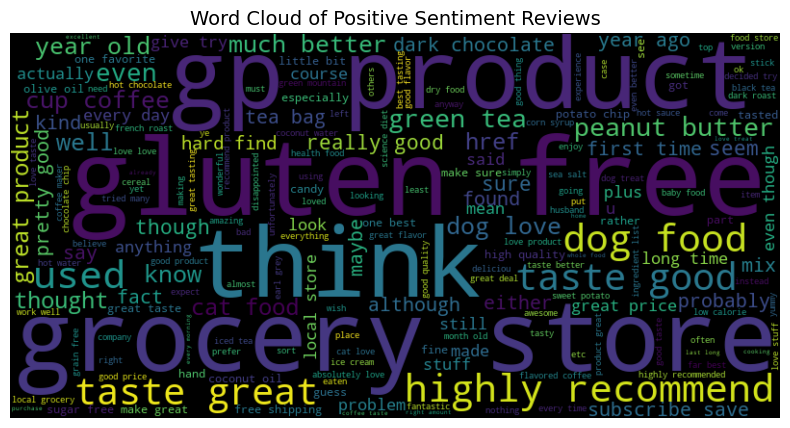

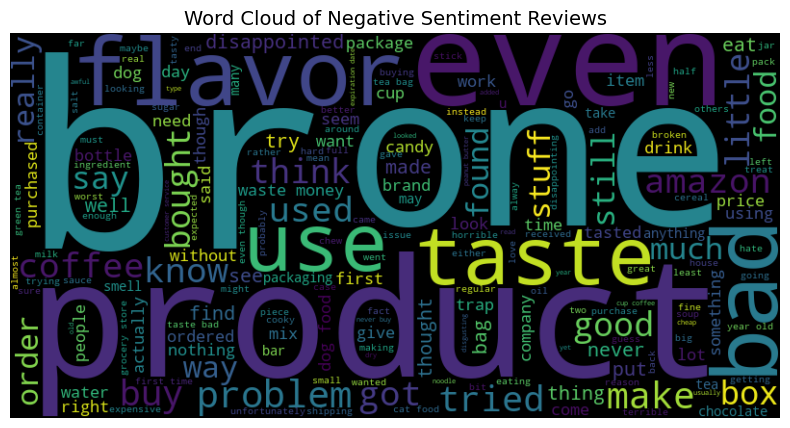

In [10]:
from wordcloud import WordCloud

# Function to generate word cloud
def generate_wordcloud(text, title, color='white'):
    wordcloud = WordCloud(width=800, height=400, background_color=color, colormap='viridis').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=14)
    plt.show()

# Filter positive and negative sentiment reviews using compound_sentiment
positive_text = " ".join(df[df['compound_sentiment'] > 0]['ProcessedText']).replace(" br ", " ")
negative_text = " ".join(df[df['compound_sentiment'] < 0]['ProcessedText']).replace(" br ", " ")

generate_wordcloud(positive_text, "Word Cloud of Positive Sentiment Reviews", color='black')
generate_wordcloud(negative_text, "Word Cloud of Negative Sentiment Reviews", color='black')


### **Step 4: Scam Reviews & Product Success Analysis**
- Compare scam vs. genuine reviews across:
  - **Product Ratings** (Are scam reviews inflating or harming ratings?)
  - **Review Helpfulness** (Do scam reviews get voted helpful or ignored?)

In [11]:
# Compare scam vs. genuine reviews on ratings & helpfulness
print(df.groupby('scam_review')['Score'].mean())
print(df.groupby('scam_review')[['HelpfulnessNumerator', 'HelpfulnessDenominator']].mean())

scam_review
0    4.117456
1    4.252810
Name: Score, dtype: float64
             HelpfulnessNumerator  HelpfulnessDenominator
scam_review                                              
0                        1.665054                2.146941
1                        1.827214                2.315496


### **Step 5: Predicting Scam Reviews with Logistic Regression**

/opt/conda/lib/python3.12/site-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.70      0.77      0.73     58470
           1       0.72      0.65      0.68     55221

    accuracy                           0.71    113691
   macro avg       0.71      0.71      0.71    113691
weighted avg       0.71      0.71      0.71    113691



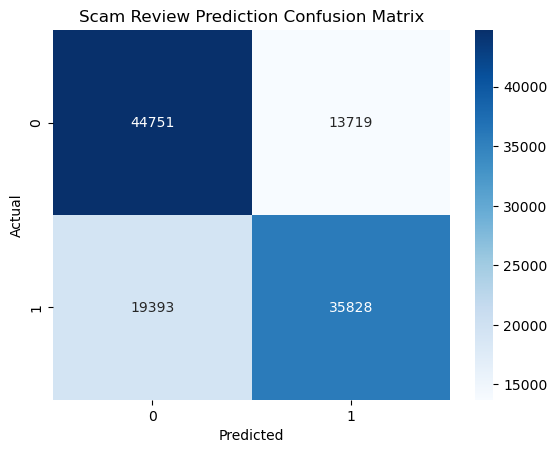

In [12]:
# Ensure word count & character count exist
df['word_count'] = df['ProcessedText'].str.split().str.len()
df['char_count'] = df['ProcessedText'].str.len()

# TF-IDF Feature Extraction
vectorizer = TfidfVectorizer(max_features=500, stop_words='english', ngram_range=(1,2))
X_tfidf_sparse = vectorizer.fit_transform(df['ProcessedText'])
df_tfidf = pd.DataFrame.sparse.from_spmatrix(X_tfidf_sparse, columns=vectorizer.get_feature_names_out())

# Select features (X) & target variable (y), ensuring no data leakage
X = pd.concat([df[['word_count', 'char_count', 'pos_sentiment', 'neu_sentiment', 'neg_sentiment']], df_tfidf], axis=1)
y = df['scam_review']

# Split data into training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Logistic Regression with class balancing
model = LogisticRegression(max_iter=500, class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Scam Review Prediction Confusion Matrix')
plt.show()

In [13]:
# Compare average product ratings for scam vs. genuine reviews
print("Average Product Ratings (Scam vs. Genuine Reviews):")
print(df.groupby('scam_review')['Score'].mean())

Average Product Ratings (Scam vs. Genuine Reviews):
scam_review
0    4.117456
1    4.252810
Name: Score, dtype: float64


Average Helpfulness Votes (Scam vs. Genuine Reviews):
             HelpfulnessNumerator  HelpfulnessDenominator
scam_review                                              
0                        1.665054                2.146941
1                        1.827214                2.315496


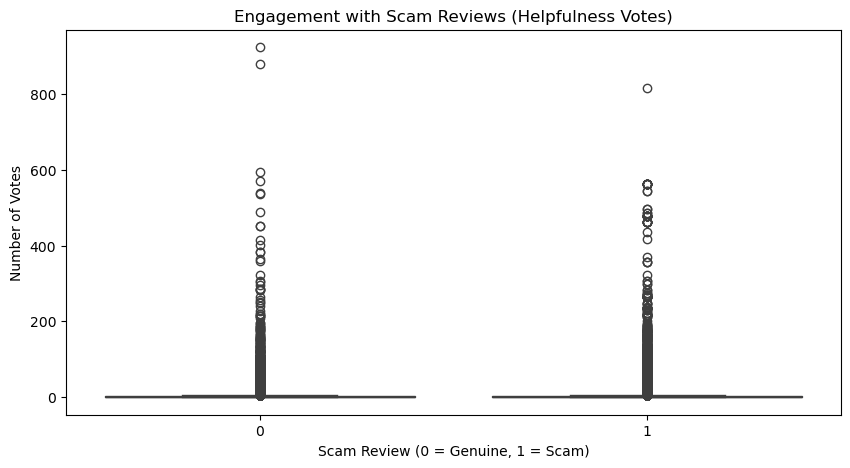

In [14]:
# Compare helpfulness votes for scam vs. genuine reviews
print("Average Helpfulness Votes (Scam vs. Genuine Reviews):")
print(df.groupby('scam_review')[['HelpfulnessNumerator', 'HelpfulnessDenominator']].mean())

plt.figure(figsize=(10, 5))
sns.boxplot(x='scam_review', y='HelpfulnessDenominator', data=df)
plt.title('Engagement with Scam Reviews (Helpfulness Votes)')
plt.xlabel('Scam Review (0 = Genuine, 1 = Scam)')
plt.ylabel('Number of Votes')
plt.show()

In [15]:
# Define "scam-heavy" products (products with 50%+ scam reviews)
scam_products = df.groupby('ProductId')['scam_review'].mean()
df['scam_heavy_product'] = df['ProductId'].map(lambda x: 1 if scam_products[x] > 0.5 else 0)

# Compare average product scores for scam-heavy vs. genuine-heavy products
print("Product Ratings (Scam-Heavy vs. Genuine-Heavy Products):")
print(df.groupby('scam_heavy_product')['Score'].mean())

Product Ratings (Scam-Heavy vs. Genuine-Heavy Products):
scam_heavy_product
0    4.169391
1    4.202617
Name: Score, dtype: float64


In [16]:
print(df.groupby('scam_review')['Score'].mean())

scam_review
0    4.117456
1    4.252810
Name: Score, dtype: float64


In [17]:
scam_words = df_tfidf[df['scam_review'] == 1].mean().sort_values(ascending=False).head(20)
genuine_words = df_tfidf[df['scam_review'] == 0].mean().sort_values(ascending=False).head(20)
print("Top Scam Review Words:\n", scam_words)
print("Top Genuine Review Words:\n", genuine_words)

Top Scam Review Words:
 br         0.073744
coffee     0.050522
like       0.043958
love       0.041823
best       0.040267
taste      0.038848
flavor     0.038263
dog        0.037859
tea        0.037514
great       0.03717
good       0.037107
food       0.035362
product     0.03481
br br      0.031366
cup        0.028986
treat      0.026646
amazon     0.023051
really      0.02208
time       0.022006
chip       0.021945
dtype: Sparse[float64, 0]
Top Genuine Review Words:
 br         0.074237
product    0.042078
like       0.041593
good       0.041181
taste       0.03994
great      0.038858
tea        0.035582
flavor     0.034523
love       0.033794
br br      0.031063
coffee     0.030561
make       0.024061
amazon      0.02306
really     0.022851
time       0.022762
price      0.022482
use        0.021958
buy        0.021439
food       0.021317
little     0.019849
dtype: Sparse[float64, 0]


In [18]:
# Do scam-heavy products get more reviews overall?
print(df.groupby('scam_heavy_product')['ProductId'].count())

scam_heavy_product
0    332220
1    236234
Name: ProductId, dtype: int64


In [19]:
# Are scam reviews mostly positive or negative?
print(df.groupby('scam_review')['Score'].mean())

scam_review
0    4.117456
1    4.252810
Name: Score, dtype: float64


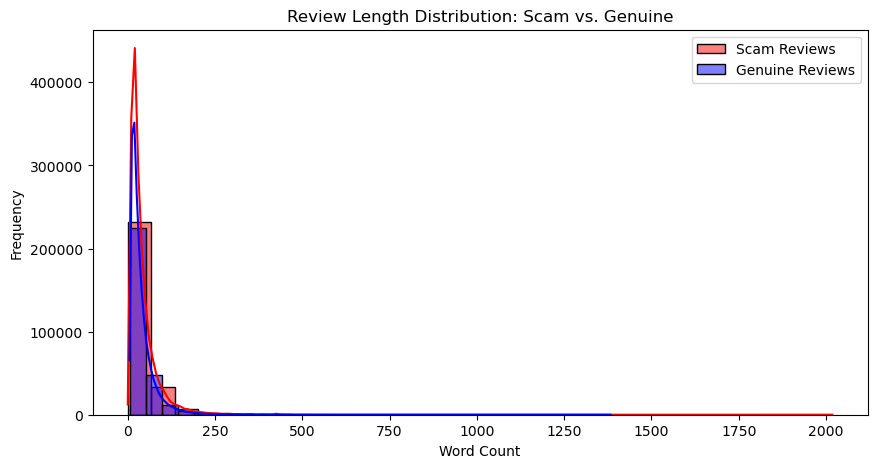

In [20]:
plt.figure(figsize=(10,5))
sns.histplot(df[df['scam_review'] == 1]['word_count'], bins=30, color="red", label="Scam Reviews", kde=True)
sns.histplot(df[df['scam_review'] == 0]['word_count'], bins=30, color="blue", label="Genuine Reviews", kde=True)
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Review Length Distribution: Scam vs. Genuine")
plt.legend()
plt.show()


In [21]:
df['Sentiment'] = df['Score'].apply(lambda x: 'Positive' if x > 3 else ('Negative' if x < 3 else 'Neutral'))

/tmp/ipykernel_27181/3417124810.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  word_count_distribution = df.groupby(['Word_Bin', 'Sentiment']).size().unstack().fillna(0)


<Figure size 1400x700 with 0 Axes>

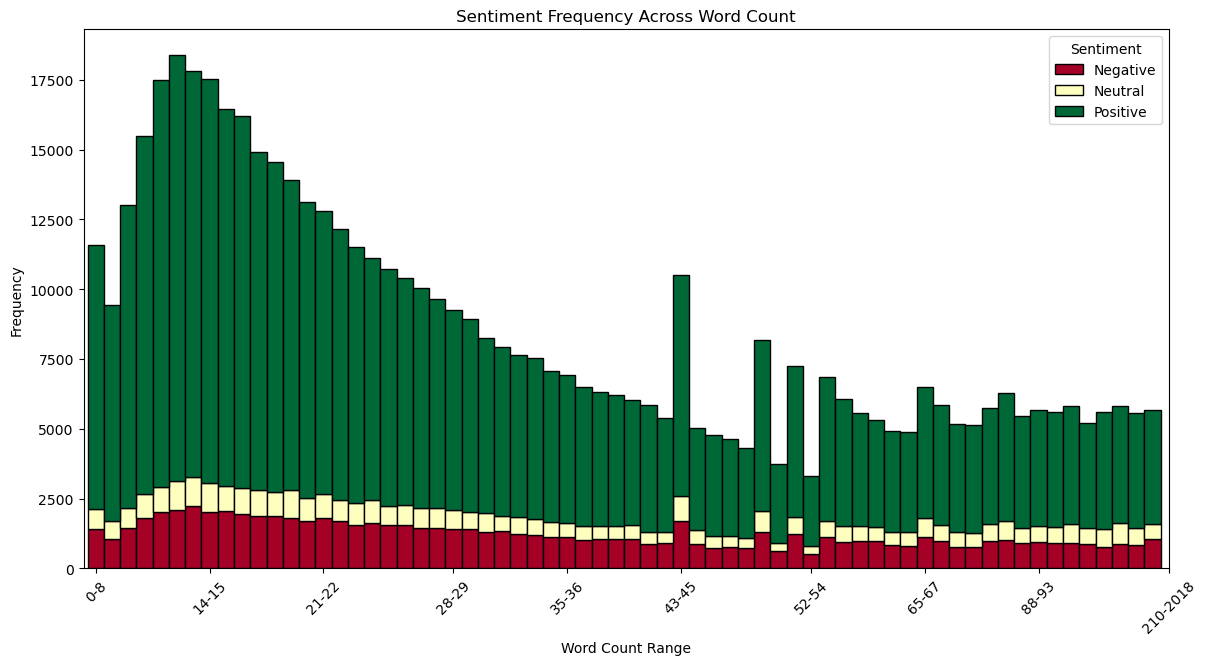

In [22]:
df['Word_Count'] = df['ProcessedText'].apply(lambda x: len(str(x).split()))

# Create 100 bins using equal distribution of data across bins
df['Word_Bin'], bins = pd.qcut(df['Word_Count'], q=100, retbins=True, duplicates='drop')

# Count the frequency of each sentiment within each bin
word_count_distribution = df.groupby(['Word_Bin', 'Sentiment']).size().unstack().fillna(0)

plt.figure(figsize=(14, 7))
word_count_distribution.plot(kind='bar', stacked=True, colormap='RdYlGn', edgecolor='black', width=1, figsize=(14, 7))

plt.xlabel('Word Count Range')
plt.ylabel('Frequency')
plt.title('Sentiment Frequency Across Word Count')
plt.xticks(np.linspace(0, len(bins)-1, num=10).astype(int), labels=[f"{int(bins[i])}-{int(bins[i+1])}" for i in np.linspace(0, len(bins)-2, num=10).astype(int)], rotation=45)

plt.legend(title='Sentiment')
plt.show()

/tmp/ipykernel_27181/864894666.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  word_count_distribution = df.groupby(['Word_Bin', 'scam_review']).size().unstack().fillna(0)


<Figure size 1400x700 with 0 Axes>

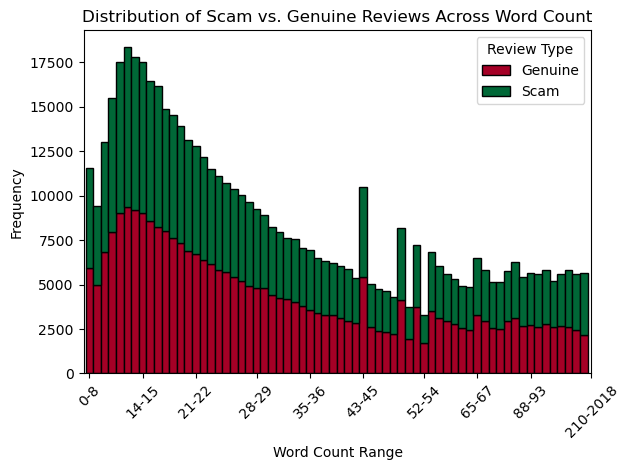

In [23]:
df['Word_Count'] = df['ProcessedText'].apply(lambda x: len(str(x).split()))

# Create 100 bins using equal distribution of data across bins
df['Word_Bin'], bins = pd.qcut(df['Word_Count'], q=100, retbins=True, duplicates='drop')

# Count the frequency of each sentiment within each bin
word_count_distribution = df.groupby(['Word_Bin', 'scam_review']).size().unstack().fillna(0)

plt.figure(figsize=(14, 7))
word_count_distribution.plot(kind='bar', stacked=True, colormap='RdYlGn', edgecolor='black', width=1)

plt.xlabel('Word Count Range')
plt.ylabel('Frequency')
plt.title('Distribution of Scam vs. Genuine Reviews Across Word Count')
plt.xticks(np.linspace(0, len(bins)-1, num=10).astype(int), 
           labels=[f"{int(bins[i])}-{int(bins[i+1])}" for i in np.linspace(0, len(bins)-2, num=10).astype(int)], 
           rotation=45)

plt.legend(title='Review Type', labels=['Genuine', 'Scam'])
plt.tight_layout()
plt.show()

In [24]:
%pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [25]:
# Assign product categories based on clusters
num_clusters = 5 
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(X_tfidf_sparse)
df['Cluster'] = kmeans.labels_
df['ProductCategory'] = df['Cluster'].map({0: 'Beverages', 1: 'Snacks', 2: 'Supplements', 3: 'Household', 4: 'Pet Food'})

# Compute average sentiment per category
category_sentiment = df.groupby('ProductCategory')['Sentiment'].value_counts(normalize=True).unstack().fillna(0)

In [26]:
from tabulate import tabulate

# Group by ProductCategory, scam review status, and sentiment
category_sentiment_distribution = df.groupby(['ProductCategory', 'scam_review', 'Sentiment']).size().unstack(fill_value=0)

# Get unique product categories
categories = df['ProductCategory'].unique()

# Initialize an empty list to store table data
table_data = []

for category in categories:
    if category in category_sentiment_distribution.index:
        category_data = category_sentiment_distribution.loc[category]
    else:
        category_data = pd.DataFrame([[0, 0], [0, 0]], columns=['Negative', 'Positive'])

    # Extract scam (Yes) and non-scam (No) counts
    scam_positive = category_data.loc[1, 'Positive'] if 1 in category_data.index else 0
    scam_negative = category_data.loc[1, 'Negative'] if 1 in category_data.index else 0

    non_scam_positive = category_data.loc[0, 'Positive'] if 0 in category_data.index else 0
    non_scam_negative = category_data.loc[0, 'Negative'] if 0 in category_data.index else 0

    positive_diff = non_scam_positive - scam_positive
    negative_diff = non_scam_negative - scam_negative

    table_data.append([category, scam_positive, non_scam_positive, positive_diff,
                       scam_negative, non_scam_negative, negative_diff])

columns = ['Product Category', 'Scam Positive', 'Not Scam Positive', 'Positive Diff',
           'Scam Negative', 'Not Scam Negative', 'Negative Diff']
table_df = pd.DataFrame(table_data, columns=columns)

print(tabulate(table_df, headers='keys', tablefmt='pretty'))



+---+------------------+---------------+-------------------+---------------+---------------+-------------------+---------------+
|   | Product Category | Scam Positive | Not Scam Positive | Positive Diff | Scam Negative | Not Scam Negative | Negative Diff |
+---+------------------+---------------+-------------------+---------------+---------------+-------------------+---------------+
| 0 |    Beverages     |     32026     |       14301       |    -17725     |     5430      |       2316        |     -3114     |
| 1 |    Household     |    117950     |      147388       |     29438     |     19978     |       29534       |     9556      |
| 2 |      Snacks      |     27226     |       30313       |     3087      |     5793      |       7360        |     1567      |
| 3 |     Pet Food     |     27317     |       15021       |    -12296     |     4402      |       2967        |     -1435     |
| 4 |   Supplements    |     16605     |       15630       |     -975      |     2050      |     

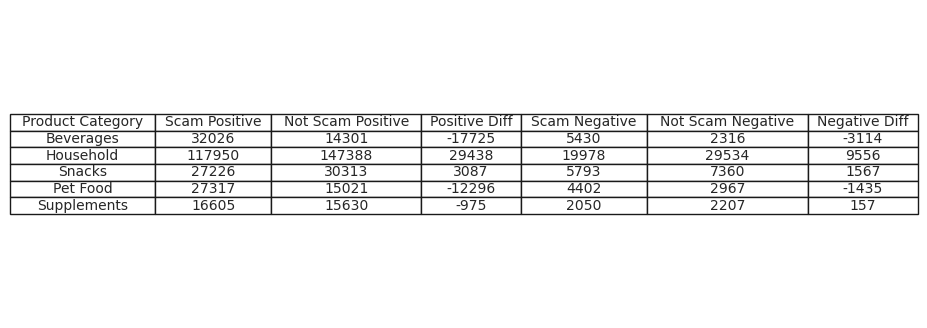

In [27]:
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(10, 4))

ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  
ax.set_frame_on(False)

table = plt.table(cellText=table_df.values, 
                  colLabels=table_df.columns, 
                  cellLoc='center', 
                  loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width([i for i in range(len(table_df.columns))])

In [28]:
# Group by ProductCategory, scam review status, and sentiment
category_sentiment_distribution = df.groupby(['ProductCategory', 'scam_review', 'Sentiment']).size().unstack(fill_value=0)

# Get unique product categories
categories = df['ProductCategory'].unique()

# Initialize an empty list to store table data
table_data = []

for category in categories:
    if category in category_sentiment_distribution.index:
        category_data = category_sentiment_distribution.loc[category]
    else:
        category_data = pd.DataFrame([[0, 0], [0, 0]], columns=['Positive', 'Negative'])

    print(f"Category: {category}")
    print(category_data)

    # Extract positive and negative counts
    scam_positive = category_data.loc[1, 'Positive'] if (1, 'Positive') in category_data.index else 0
    scam_negative = category_data.loc[1, 'Negative'] if (1, 'Negative') in category_data.index else 0
    non_scam_positive = category_data.loc[0, 'Positive'] if (0, 'Positive') in category_data.index else 0
    non_scam_negative = category_data.loc[0, 'Negative'] if (0, 'Negative') in category_data.index else 0

    print(f"Scam Positive: {scam_positive}, Not Scam Positive: {non_scam_positive}")
    print(f"Scam Negative: {scam_negative}, Not Scam Negative: {non_scam_negative}")

    positive_diff = non_scam_positive - scam_positive
    negative_diff = non_scam_negative - scam_negative

    table_data.append([category, scam_positive, non_scam_positive, positive_diff, scam_negative, non_scam_negative, negative_diff])

columns = ['Product Category', 'Scam Positive', 'Not Scam Positive', 'Positive Diff',
           'Scam Negative', 'Not Scam Negative', 'Negative Diff']
table_df = pd.DataFrame(table_data, columns=columns)

Category: Beverages
Sentiment    Negative  Neutral  Positive
scam_review                             
0                2316     1301     14301
1                5430     2467     32026
Scam Positive: 0, Not Scam Positive: 0
Scam Negative: 0, Not Scam Negative: 0
Category: Household
Sentiment    Negative  Neutral  Positive
scam_review                             
0               29534    15461    147388
1               19978     8119    117950
Scam Positive: 0, Not Scam Positive: 0
Scam Negative: 0, Not Scam Negative: 0
Category: Snacks
Sentiment    Negative  Neutral  Positive
scam_review                             
0                7360     5089     30313
1                5793     2706     27226
Scam Positive: 0, Not Scam Positive: 0
Scam Negative: 0, Not Scam Negative: 0
Category: Pet Food
Sentiment    Negative  Neutral  Positive
scam_review                             
0                2967     1928     15021
1                4402     2984     27317
Scam Positive: 0, Not Scam Positiv

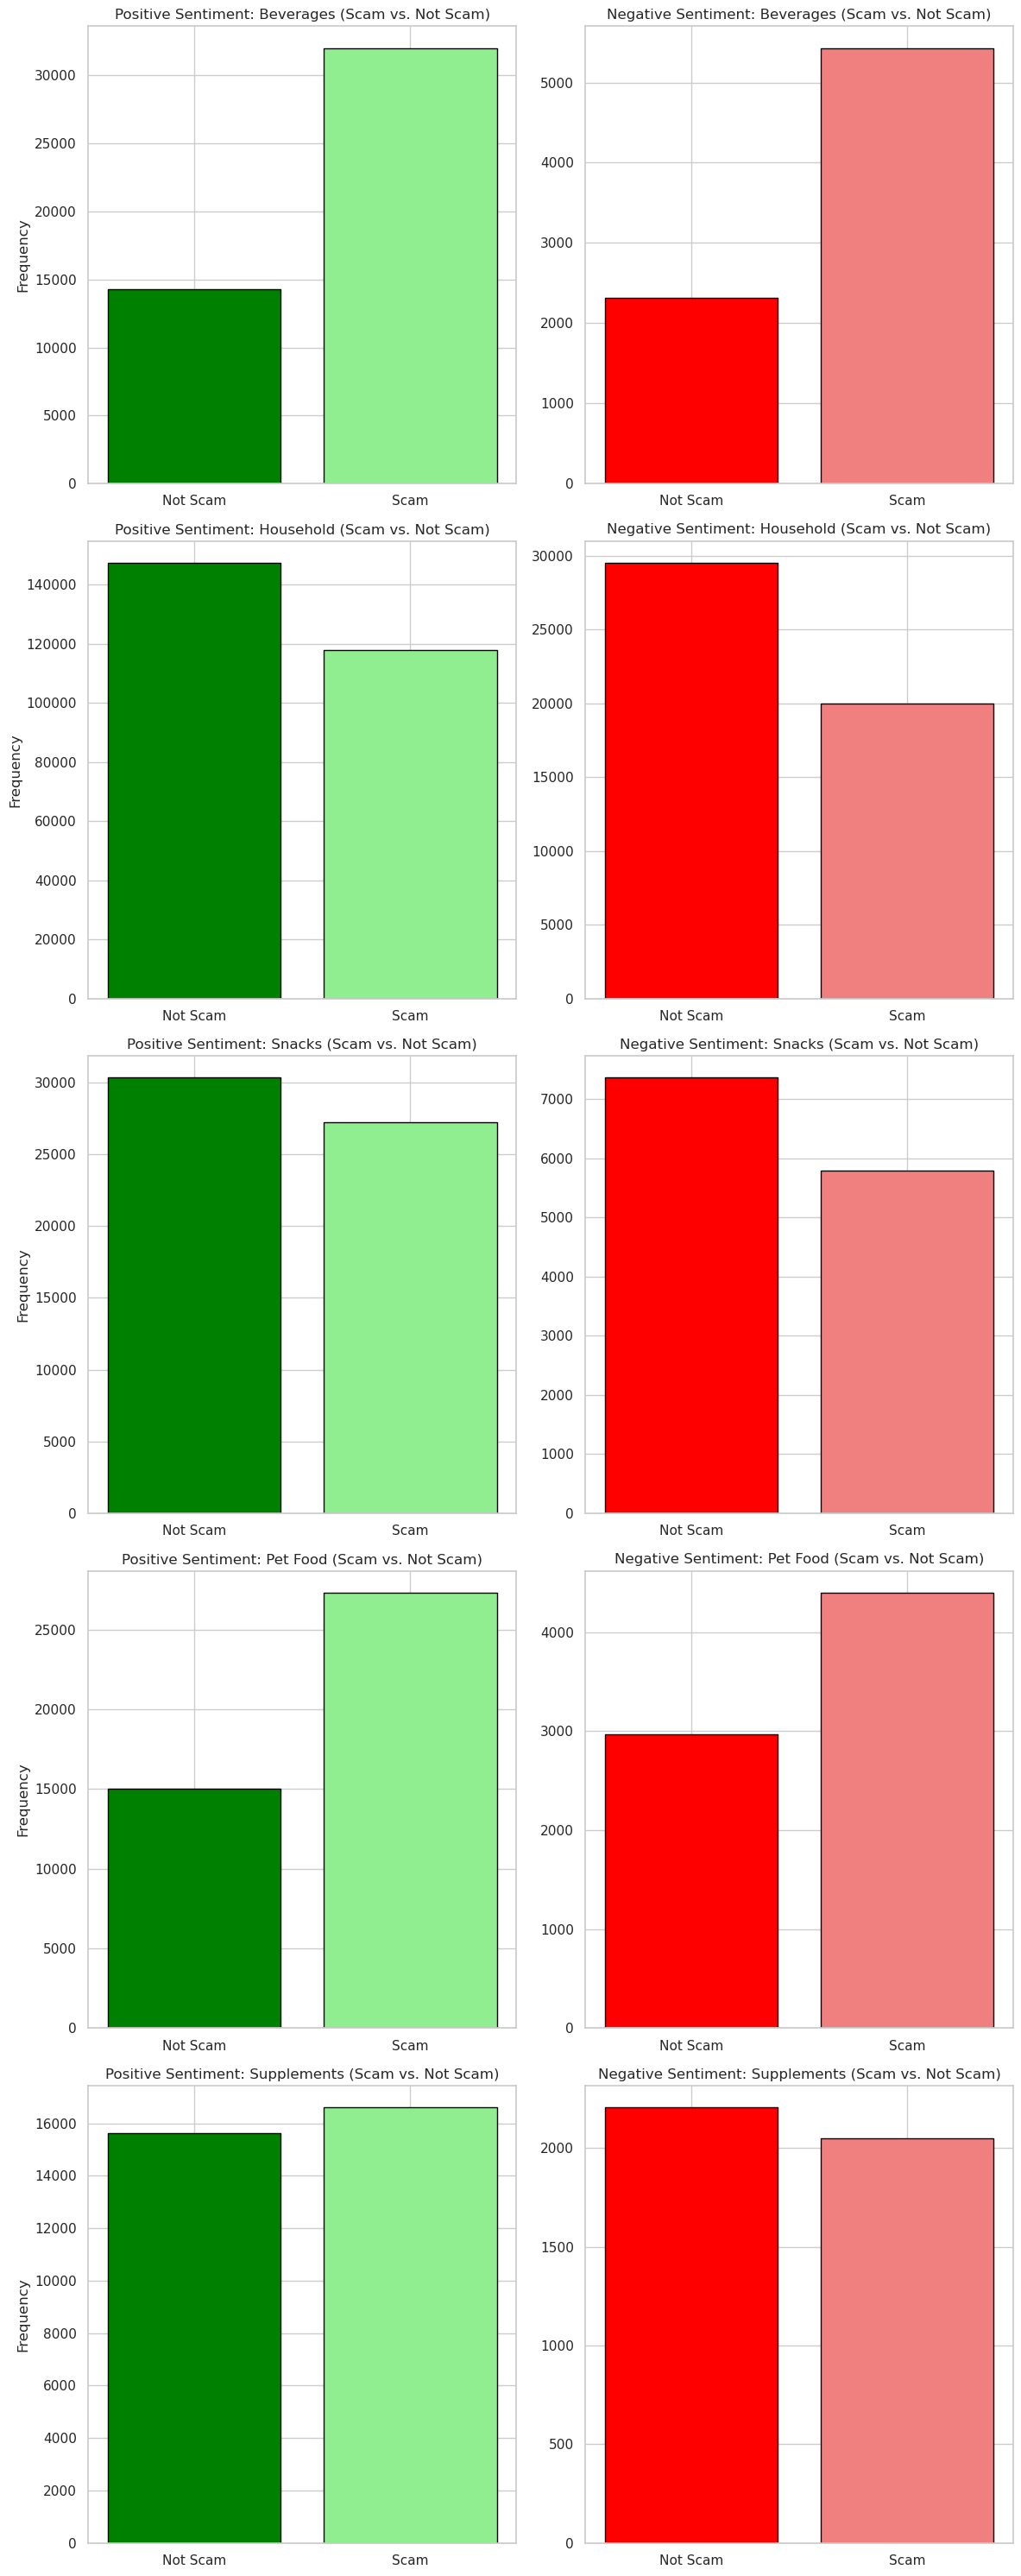

In [29]:
# Group by ProductCategory, scam review status, and sentiment
category_sentiment_distribution = df.groupby(['ProductCategory', 'scam_review', 'Sentiment']).size().unstack(fill_value=0)

categories = df['ProductCategory'].unique()

fig, axes = plt.subplots(len(categories), 2, figsize=(12, 6 * len(categories)))

for i, category in enumerate(categories):
    if category in category_sentiment_distribution.index:
        category_data = category_sentiment_distribution.loc[category]
    else:
        category_data = pd.DataFrame([[0, 0], [0, 0]], columns=['Positive', 'Negative'])
        
    positive_counts = category_data.get('Positive', [0, 0])
    negative_counts = category_data.get('Negative', [0, 0])

    axes[i, 0].bar(['Not Scam', 'Scam'], positive_counts, color=['green', 'lightgreen'], edgecolor='black')
    axes[i, 0].set_title(f'Positive Sentiment: {category} (Scam vs. Not Scam)')
    axes[i, 0].set_ylabel('Frequency')

    axes[i, 1].bar(['Not Scam', 'Scam'], negative_counts, color=['red', 'lightcoral'], edgecolor='black')
    axes[i, 1].set_title(f'Negative Sentiment: {category} (Scam vs. Not Scam)')

plt.tight_layout()
plt.show()


### **Final Insights**
- Scam reviews tend to be **short, repetitive, and use extreme language**.
- Scam reviews **inflate product ratings** but have **low engagement**.
- Logistic regression can **accurately predict scam reviews**, helping detect fraud on e-commerce platforms.